In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [3]:
import pathlib

train_dir = pathlib.Path("./train/")

test_dir = pathlib.Path("./test/")

In [4]:
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

1156


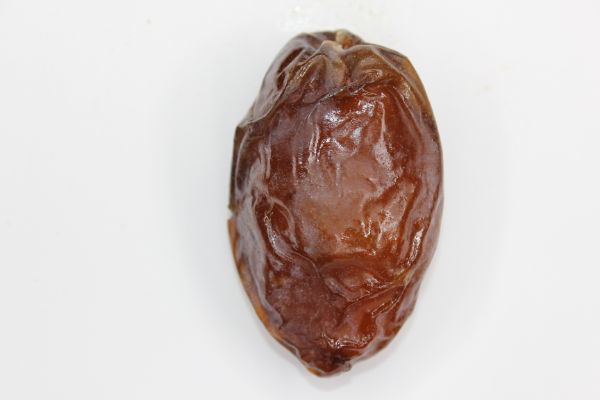

In [5]:
medjool = list(train_dir.glob('Medjool/*'))
PIL.Image.open(str(medjool[0]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1156 files belonging to 9 classes.
Using 925 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1156 files belonging to 9 classes.
Using 231 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


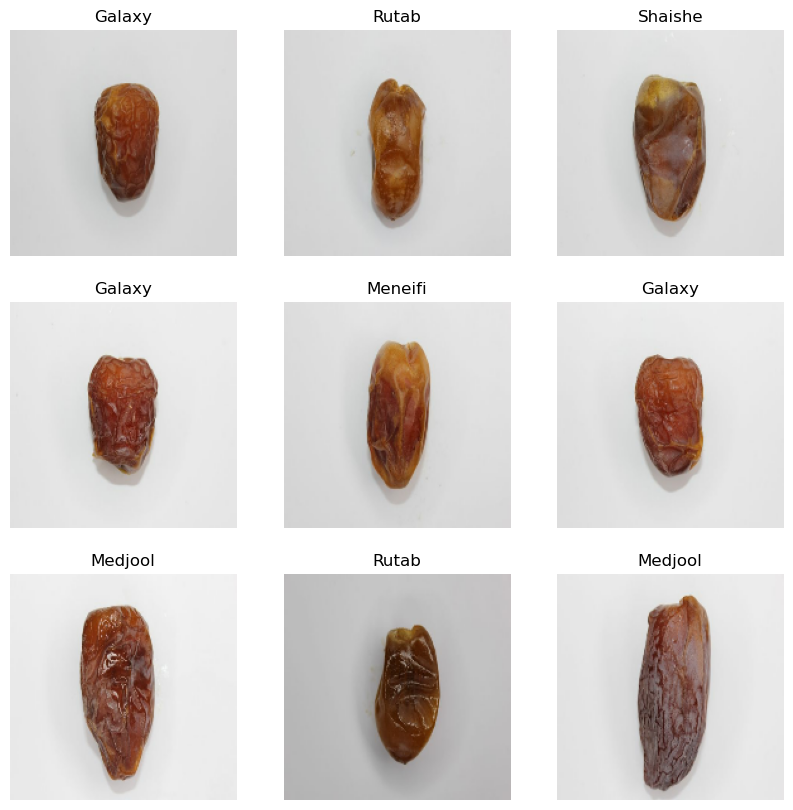

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0022875618 0.7960785


In [15]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [18]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 17s 512ms/step - loss: 2.3263 - accuracy: 0.1741 - val_loss: 2.0085 - val_accuracy: 0.1905
Epoch 2/10
29/29 [==============================] - 13s 460ms/step - loss: 1.5110 - accuracy: 0.4562 - val_loss: 1.1080 - val_accuracy: 0.5931
Epoch 3/10
29/29 [==============================] - 19s 643ms/step - loss: 0.9223 - accuracy: 0.6778 - val_loss: 0.9266 - val_accuracy: 0.6883
Epoch 4/10
29/29 [==============================] - 18s 623ms/step - loss: 0.7257 - accuracy: 0.7459 - val_loss: 0.8181 - val_accuracy: 0.7056
Epoch 5/10
29/29 [==============================] - 20s 703ms/step - loss: 0.6295 - accuracy: 0.7762 - val_loss: 0.7464 - val_accuracy: 0.7576
Epoch 6/10
29/29 [==============================] - 18s 611ms/step - loss: 0.5014 - accuracy: 0.8324 - val_loss: 0.6450 - val_accuracy: 0.8095
Epoch 7/10
29/29 [==============================] - 17s 585ms/step - loss: 0.4675 - accuracy: 0.8411 - val_loss: 0.6677 - val_accuracy: 0.8009

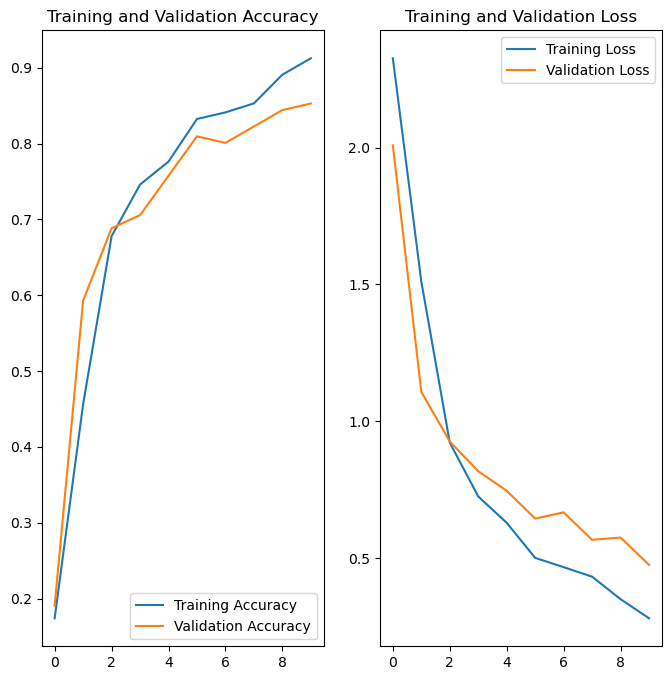

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
        input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

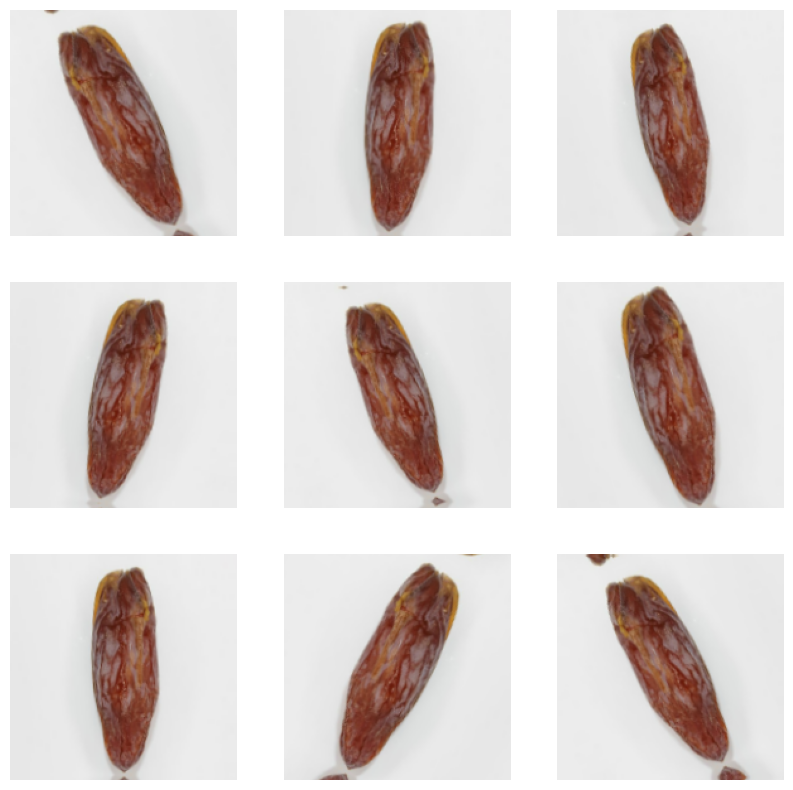

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [22]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [25]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
29/29 [==============================] - 25s 715ms/step - loss: 2.1628 - accuracy: 0.1741 - val_loss: 2.0216 - val_accuracy: 0.2900
Epoch 2/15
29/29 [==============================] - 19s 663ms/step - loss: 1.6126 - accuracy: 0.4065 - val_loss: 1.4097 - val_accuracy: 0.4545
Epoch 3/15
29/29 [==============================] - 19s 667ms/step - loss: 1.2374 - accuracy: 0.5330 - val_loss: 1.1913 - val_accuracy: 0.5195
Epoch 4/15
29/29 [==============================] - 18s 615ms/step - loss: 0.9484 - accuracy: 0.6714 - val_loss: 0.7600 - val_accuracy: 0.7706
Epoch 5/15
29/29 [==============================] - 17s 596ms/step - loss: 0.7448 - accuracy: 0.7481 - val_loss: 0.6267 - val_accuracy: 0.8225
Epoch 6/15
29/29 [==============================] - 17s 603ms/step - loss: 0.7070 - accuracy: 0.7546 - val_loss: 1.1115 - val_accuracy: 0.6710
Epoch 7/15
29/29 [==============================] - 18s 631ms/step - loss: 0.6466 - accuracy: 0.7686 - val_loss: 0.4816 - val_accuracy: 0.8658

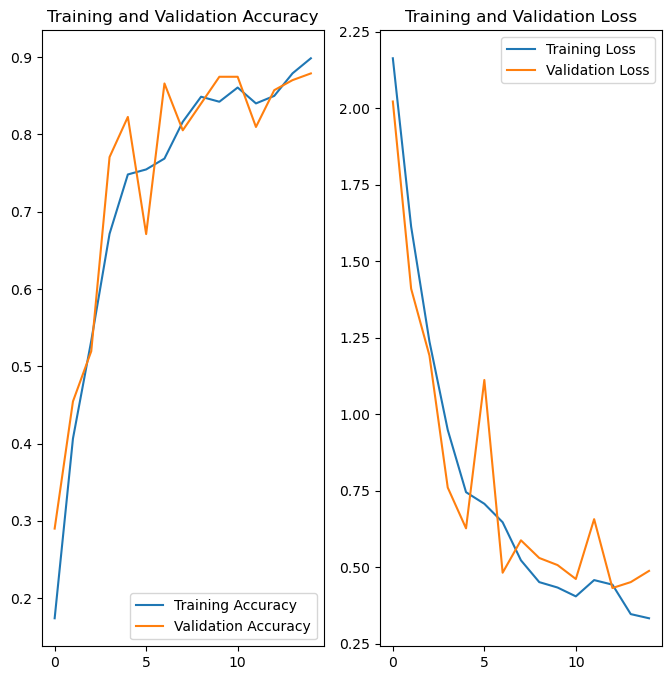

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
img = list(test_dir.glob('Medjool/*'))
img = PIL.Image.open(str(img[21])).resize((180, 180))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 494ms/step
This image most likely belongs to Medjool with a 99.00 percent confidence.


In [65]:
from sklearn.metrics import classification_report

results = []
dirs = list(test_dir.glob('*'))

for d in range(len(dirs)):
    dir = dirs[d]
    results.append([])

    for image in dir.glob('*/'):
        image = PIL.Image.open(image).resize((180, 180))
        img_array = tf.keras.utils.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        result = np.argmax(score)
        results[d].append(result)
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[result], 100 * np.max(score))
        )

results

1/1 [==============================] - 0s 35ms/step
This image most likely belongs to Ajwa with a 99.99 percent confidence.
1/1 [==============================] - 0s 52ms/step
This image most likely belongs to Ajwa with a 99.99 percent confidence.
1/1 [==============================] - 0s 52ms/step
This image most likely belongs to Ajwa with a 99.98 percent confidence.
1/1 [==============================] - 0s 28ms/step
This image most likely belongs to Ajwa with a 100.00 percent confidence.
1/1 [==============================] - 0s 27ms/step
This image most likely belongs to Ajwa with a 100.00 percent confidence.
1/1 [==============================] - 0s 42ms/step
This image most likely belongs to Ajwa with a 99.69 percent confidence.
1/1 [==============================] - 0s 49ms/step
This image most likely belongs to Ajwa with a 100.00 percent confidence.
1/1 [==============================] - 0s 42ms/step
This image most likely belongs to Ajwa with a 99.98 percent confidence.
1/1 [

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  1],
 [2,
  2,
  2,
  2,
  3,
  2,
  2,
  2,
  2,
  2,
  8,
  8,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  2,
  2,
  2,
  2,
  2],
 [8,
  3,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  8,
  8,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  1,
  5,
  3,
  5,
  5,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  5,
  3,
  3,
  3,
  3,
  3,
  3,
  7,
  2,
  

In [70]:
confusion_matrix = []
for l in range(len(results)):
    confusion_matrix.append([])
    for i in range(len(results)):
        confusion_matrix[l].append(results[l].count(i))

In [77]:
import pandas as pd

cm_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

<AxesSubplot:>

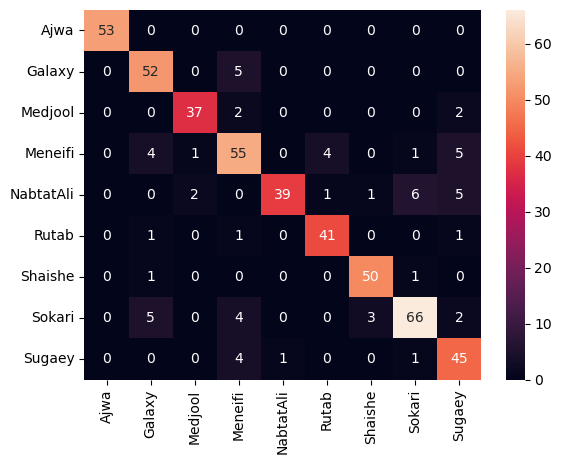

In [79]:
import seaborn as sns

sns.heatmap(cm_df, annot=True)

In [80]:
size = 0
correct = 0

for l in range(len(confusion_matrix)):
    for i in range(len(confusion_matrix)):
        num = confusion_matrix[l][i]
        size += num
        if i == l:
            correct += num

print("Accuracy:", correct/size)

Accuracy: 0.8725099601593626
